In [42]:
print('hello world')

#!pip install qutip

hello world


In [43]:
#Aprendendo o QuTip

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import qutip as qtp

%matplotlib inline

a = qtp.fock(2,1) #primeira entrada é a dimensão, a segunda é o estado populado

b = qtp.coherent(10, 0.1) #cria um estado coerente com N=10, alpha=0.1

#Representando esses mesmos estados com a matriz densidade:

qtp.fock_dm(6,1)

c = qtp.coherent_dm(6, 0.1)

term = qtp.thermal_dm(6, 0.5) #estado térmico, segundo argumento é o número médio de fótons térmicos.

print(a)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]


0.10000000000000003
A fidelidade desses estados é: 0.9110936148710452
A distância de Bures desses estados é: 0.42167851529086653


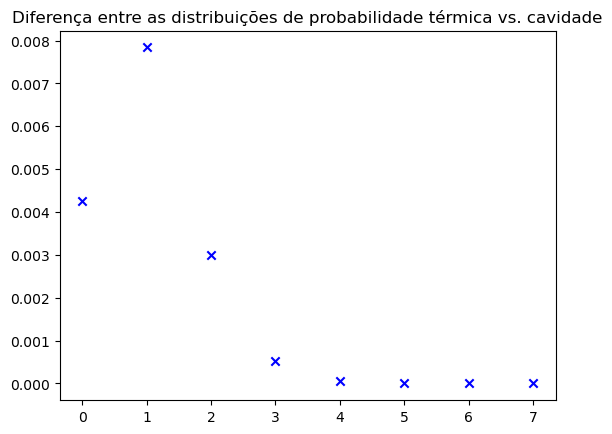

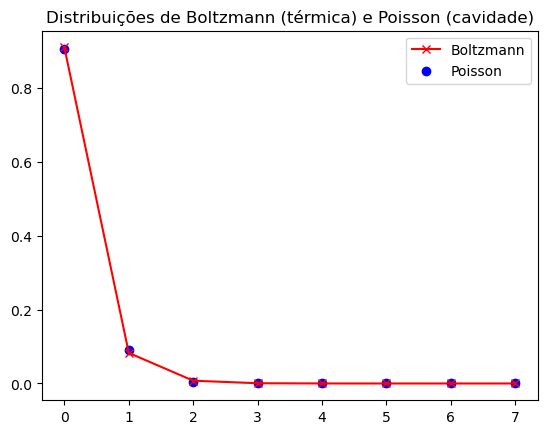

In [44]:
#Checando fidelidade do estado térmico construído na cavidade

import scipy.special

#Estado preparado:

alpha_cav = 0.1*np.sqrt(10)
nmed_cav = alpha_cav**2
print(nmed_cav)

estd_cav = qtp.coherent_dm(8, alpha_cav)

P_n = np.array([np.exp(-nmed_cav)*(nmed_cav**i)/(scipy.special.factorial(i)) for i in range(0,8)])

#Estado térmico:

n_th = nmed_cav

P_c = np.array([n_th**n/((1+n_th)**(n+1)) for n in range(0,8)])

estd_termico = 0*qtp.fock_dm(8,0)

for i in range(0,8):
    estd_termico = P_c[i]*qtp.fock_dm(8, i) + estd_termico

#Calculando a fidelidade:

fidelidade = qtp.fidelity(estd_cav, estd_termico)
bures = qtp.bures_dist(estd_cav, estd_termico)
print('A fidelidade desses estados é:', fidelidade)
print('A distância de Bures desses estados é:', bures)

#Plotando distribuições

n = [i for i in range(0,8)]

plt.scatter(n, np.abs(P_c-P_n), marker='x', color='blue')
#plt.plot(n, P_n, marker='o')
plt.title('Diferença entre as distribuições de probabilidade térmica vs. cavidade')
plt.show()

plt.plot(n, P_c, marker='x', color='red', label='Boltzmann')
plt.scatter(n, P_n, marker='o', label='Poisson', color='blue')
plt.legend()
plt.title('Distribuições de Boltzmann (térmica) e Poisson (cavidade)')
plt.show()

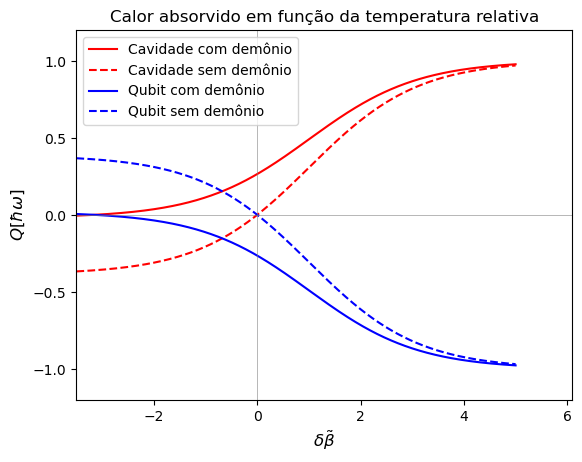

In [45]:
#Plotando o calor recebido pela cavidade

N = 5000 #número de pontos no gráfico
eta = 0.95 #eficiência de leitura
delta_beta = np.linspace(-3.5, 5, N)
p_e = 1/(np.exp(eta*(1-delta_beta))+1) #população do estado térmico excitado do qubit
n_0 = 0.63 #número inicial de fótons na cavidade

#Façamos um range inicial de 20 termos para a soma em n_f

P_c = np.array([n_0**i/((1+n_0)**(i+1)) for i in range(0,100)])
n_f_d = 0
n_f_sd = 0
n_f_lista_dem = np.zeros(N) #com demonio
n_f_lista_sdem = np.zeros(N) #sem demonio
for j in range(0,N):
    for i in range(0,20):
        n_f_d = n_f_d + i*P_c[i]*eta*(1-p_e[j]) + (i+1)*P_c[i+2]*(1-eta)*(1-p_e[j]) + (i+1)*P_c[i]*p_e[j]
        n_f_sd = n_f_sd + (i+1)*P_c[i+2]*(1-p_e[j]) + (i+1)*P_c[i]*p_e[j]
    n_f_lista_dem[j] = n_f_d
    n_f_lista_sdem[j] = n_f_sd
    n_f_d = 0
    n_f_sd = 0

#Calculando lista final: 

delta_n_dem = n_f_lista_dem - n_0
delta_n_sdem = n_f_lista_sdem - n_0

#Calculando o calor recebido pelo qubit:

p_e_final_dem = (1-eta)*(1-P_c[0])*(1-p_e) #com demonio
p_e_final_sdem = (1-P_c[0])*(1-p_e) #sem demonio
delta_p_e_dem = p_e_final_dem - p_e
delta_p_e_sdem = p_e_final_sdem - p_e

#Plotando resultados...

plt.plot(delta_beta, delta_n_dem, color='red', label='Cavidade com demônio')
plt.plot(delta_beta, delta_n_sdem, '--', color='red', label='Cavidade sem demônio')
plt.plot(delta_beta, delta_p_e_dem, color='blue', label='Qubit com demônio')
plt.plot(delta_beta, delta_p_e_sdem, '--', color='blue', label='Qubit sem demônio')
plt.ylim([-1.2, 1.2])
plt.xlim([-3.5, 6.1])
plt.title('Calor absorvido em função da temperatura relativa')
plt.axhline(y = 0, color = 'gray', linewidth = 0.4)
plt.axvline(x = 0, color = 'gray', linewidth = 0.4)
plt.xlabel(r'$\delta\tilde{\beta}$', size=12)
plt.ylabel(r'$Q[\hbar\omega]$', size=12)
plt.legend()
plt.show()

#aaaa

In [46]:
#Calculando informação mútua

#Etapa de readout

M = 8 #limite superior das somas sobre a dist. de Boltzmann
gibbs_cav = qtp.thermal_dm(M,n_0)
gibbs_qubit = [qtp.thermal_dm(2, p_e[i]) for i in range(0, N)]

#Estado do demônio:

rho_d_readout = [(p_e[i] + (1-p_e[i])*(1-eta))*qtp.fock_dm(2, 0) + eta * (1-p_e[i])* qtp.fock_dm(2, 1) for i in range(0,N)] 

#Estado do subsistema QC:

rho_qc_readout = [0 for i in range(0,N)]
rho_qc_rd = 0 #rho_qc para uma temperatura individual
for j in range(0,N):
    for i in range(0,M):
        rho_qc_rd = rho_qc_rd + P_c[i]*(p_e[j]*qtp.tensor(qtp.fock_dm(2, 1), qtp.fock_dm(M, i)) 
                                     + (1-p_e[j])*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(M, i)))
    rho_qc_readout[j] = rho_qc_rd
    rho_qc_rd = 0
    
#Estado global:
    
rho_qdc_readout = [0 for i in range(0,N)]
rho_qdc_rd = 0 #rho_qdc para uma temperatura individual
for j in range(0,N):
    for i in range(0,M):
        rho_qdc_rd = rho_qdc_rd + P_c[i]*(p_e[j]*qtp.tensor(qtp.fock_dm(2, 1), qtp.fock_dm(2, 0), qtp.fock_dm(M, i)) 
                                     + (1-eta)*(1-p_e[j])*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(2, 0), qtp.fock_dm(M, i))
                                         + eta * (1-p_e[j])*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(2, 1), qtp.fock_dm(M, i)))
    rho_qdc_readout[j] = rho_qdc_rd
    rho_qdc_rd = 0
    
#Cálculo da informação mútua via I(A:B) = S_A + S_B - S_AB

info_mutua_readout = np.array([-qtp.entropy_vn(rho_qdc_readout[i], base=2.718281828459045, sparse=False) +  qtp.entropy_vn(rho_qc_readout[i], base=2.718281828459045, sparse=False)
              + qtp.entropy_vn(rho_d_readout[i], base=2.718281828459045, sparse=False) for i in range(0,N)])

    


In [47]:
#Informação mútua após feedback:

rho_d_feedback = rho_d_readout #o estado do demônio não se altera no feedback

rho_qc_feedback = [0 for i in range(0,N)]
rho_qdc_feedback = [0 for i in range(0,N)]
rho_qc_fb = 0 
rho_qdc_fb = 0 
for j in range(0,N):
    for i in range(0,M):
        if i == 0:
            rho_qc_fb = (rho_qc_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(M, i)) 
            + P_c[i+1]*(1-eta)*(1-p_e[j])*qtp.tensor(qtp.fock_dm(2,1), qtp.fock_dm(M, i)) 
            + P_c[i]*p_e[j]*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(M,i+1))
            + P_c[i]*(1-eta)*(1-p_e[j])*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(M,i)))
            #----------------------------------
            rho_qdc_fb = (rho_qdc_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(2,1), qtp.fock_dm(M, i)) 
            + P_c[i+1]*(1-eta)*(1-p_e[j])*qtp.tensor(qtp.fock_dm(2,1), qtp.fock_dm(2,0), qtp.fock_dm(M, i)) 
            + P_c[i]*p_e[j]*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(2,0), qtp.fock_dm(M,i+1))
            + P_c[i]*(1-eta)*(1-p_e[j])*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(2, 0), qtp.fock_dm(M,i)))
        else:
            if i < M-1:
                rho_qc_fb = (rho_qc_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(M, i)) 
                + P_c[i+1]*(1-eta)*(1-p_e[j])*qtp.tensor(qtp.fock_dm(2,1), qtp.fock_dm(M, i)) 
                + P_c[i]*p_e[j]*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(M,i+1)))
                #------------------------------------------------------
                rho_qdc_fb = (rho_qdc_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(2,1), qtp.fock_dm(M, i)) 
                + P_c[i+1]*(1-eta)*(1-p_e[j])*qtp.tensor(qtp.fock_dm(2,1), qtp.fock_dm(2,0), qtp.fock_dm(M, i)) 
                + P_c[i]*p_e[j]*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(2,0), qtp.fock_dm(M,i+1)))
            else:
                rho_qc_fb = (rho_qc_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(M, i)) 
                + P_c[i+1]*(1-eta)*(1-p_e[j])*qtp.tensor(qtp.fock_dm(2,1), qtp.fock_dm(M, i))) 
                #-------------------------------------------------------
                rho_qdc_fb = (rho_qdc_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.tensor(qtp.fock_dm(2, 0), qtp.fock_dm(2,1), qtp.fock_dm(M, i)) 
                + P_c[i+1]*(1-eta)*(1-p_e[j])*qtp.tensor(qtp.fock_dm(2,1), qtp.fock_dm(2,0), qtp.fock_dm(M, i))) 
    rho_qc_feedback[j] = rho_qc_fb
    rho_qdc_feedback[j] = rho_qdc_fb
    rho_qc_fb = 0
    rho_qdc_fb = 0

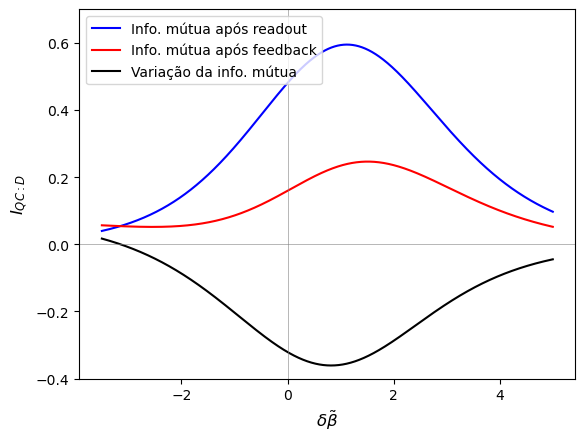

In [48]:
info_mutua_feedback = np.array([(qtp.entropy_vn(rho_qc_feedback[i], base=2.718281828459045, sparse=False)
              + qtp.entropy_vn(rho_d_feedback[i], base=2.718281828459045, sparse=False) 
                - qtp.entropy_vn(rho_qdc_feedback[i], base=2.718281828459045, sparse = False)) for i in range(0,N)])

#Variação da informação mútua na interação com a cavidade

delta_info_mutua = info_mutua_feedback - info_mutua_readout

#Plotando resultados:

plt.plot(delta_beta, info_mutua_readout, color='blue', label='Info. mútua após readout')
plt.plot(delta_beta, info_mutua_feedback, color='red', label='Info. mútua após feedback')
plt.plot(delta_beta, delta_info_mutua, color='black', label='Variação da info. mútua')
plt.ylim([-0.4, 0.7])
plt.axhline(y = 0, color = 'gray', linewidth = 0.4)
plt.axvline(x = 0, color = 'gray', linewidth = 0.4)
plt.xlabel(r'$\delta\tilde{\beta}$', size=12)
plt.ylabel(r'$I_{QC:D}$', size=12)
plt.legend()
plt.show()

Para o gráfico de $Q_c \delta \beta$, escrevemos $Q_c \delta \beta = \left(\frac{Q_c}{\hbar\omega}\right)(\hbar\omega\beta_c)\cdot\delta\tilde{\beta}$, com $\hbar\omega\beta_c = 0.9$

In [49]:
#Avaliando a SLT generalizada

Qc_deltabeta = 0.9 * delta_n_dem * delta_beta

y = Qc_deltabeta - delta_info_mutua

Text(0, 0.5, '$Q_C\\delta\\beta - \\Delta I_{QC:D}$')

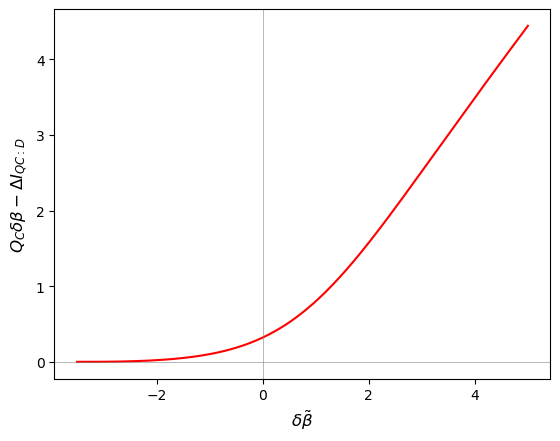

In [50]:
#Plotando a SLT generalizada

plt.plot(delta_beta, y, color='red')
plt.axhline(y = 0, color = 'gray', linewidth = 0.4)
plt.axvline(x = 0, color = 'gray', linewidth = 0.4)
plt.xlabel(r'$\delta\tilde{\beta}$', size=12)
plt.ylabel(r'$Q_C\delta\beta - \Delta I_{QC:D}$', size=12)

In [52]:
#Entropia relativa

#gibbs_qc = [qtp.tensor(gibbs_qubit[j], gibbs_cav) for j in range(0,N)]

#Obtendo D_q e D_c:

#rho_q_feedback = [0 for i in range(0,N)]
#rho_c_feedback = [0 for i in range(0,N)]
#rho_q_fb = 0 
#rho_c_fb = 0 
#for j in range(0,N):
#    rho_q_fb = ((1-P_c[0])*(1-eta)*(1-p_e[j])*qtp.fock_dm(2,1) 
#                + (p_e[j] + eta*(1-p_e[j])
#                   +(1-eta)*(1-p_e[j])*P_c[0])*qtp.fock_dm(2,0))
#    for i in range(0,M):
#        if i == 0:
#            rho_c_fb = (rho_c_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.fock_dm(M, i) 
#                        + P_c[i+1]*(1-eta)*(1-p_e[j])*qtp.fock_dm(M, i) 
#                        + P_c[i]*p_e[j]*qtp.fock_dm(M,i+1) + P_c[i]*(1-eta)*(1-p_e[j])*qtp.fock_dm(M,i))
#        else:
#            if i < M-1:
#                rho_c_fb = (rho_c_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.fock_dm(M, i) 
#                + P_c[i+1]*(1-eta)*(1-p_e[j])*qtp.fock_dm(M, i) 
#                + P_c[i]*p_e[j]*qtp.fock_dm(M,i+1))
#            else:
#                rho_c_fb = (rho_c_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.fock_dm(M, i) 
#                + P_c[i+1]*(1-eta)*(1-p_e[j])qtp.fock_dm(M, i)) 
#    rho_c_feedback[j] = rho_c_fb
#    rho_q_feedback[j] = rho_q_fb
#    rho_c_fb = 0
#D_q = np.array([qtp.entropy_relative(rho_q_feedback[j], gibbs_qubit[j], base=2.718281828459045, sparse=False) for j in range(0,N)])
#D_cav = np.array([qtp.entropy_relative(rho_c_feedback[j], gibbs_cav[j], base=2.718281828459045, sparse=False) for j in range(0,N)])

#info mutua:

#info_mutua_qc = np.array([(qtp.entropy_vn(rho_q_feedback[i], base=2.718281828459045, sparse=False) 
                         #  + qtp.entropy_vn(rho_c_feedback[i], base=2.718281828459045, sparse=False)
                         #  - qtp.entropy_vn(rho_qc_feedback[i], base=2.718281828459045, sparse=False)) for i in range(0,N)])

#Obtendo D_qc:

#D_qc = D_q + D_cav - info_mutua_qc

#plt.plot(delta_beta, D_qc, color='black')
#plt.axhline(y = 0, color = 'gray', linewidth = 0.4)
#plt.axvline(x = 0, color = 'gray', linewidth = 0.4)
#plt.xlabel(r'$\delta\tilde{\beta}$', size=12)
#plt.ylabel(r'$D_{QC}$', size=12)

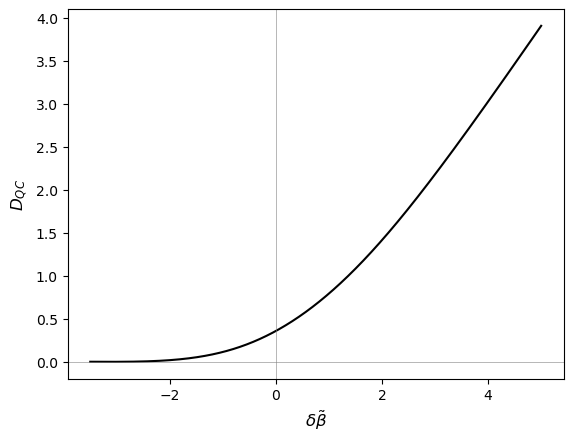

In [54]:
rho_q_feedback = [0 for i in range(0,N)]
rho_c_feedback = [0 for i in range(0,N)]
rho_q_fb = 0 
rho_c_fb = 0 

for j in range(0,N):
    rho_q_fb = ((1-P_c[0])*(1-eta)*(1-p_e[j])*qtp.fock_dm(2,1) 
                + (p_e[j] + eta*(1-p_e[j])
                   +(1-eta)*(1-p_e[j])*P_c[0])*qtp.fock_dm(2,0))
    for i in range(0,M):
        if i == 0:
            rho_c_fb = rho_c_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.fock_dm(M, i) + P_c[i+1]*(1-eta)*(1-p_e[j])*qtp.fock_dm(M, i) + P_c[i]*p_e[j]*qtp.fock_dm(M,i+1) + P_c[i]*(1-eta)*(1-p_e[j])*qtp.fock_dm(M,i)
        else:
            if i < M-1:
                rho_c_fb = rho_c_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.fock_dm(M, i) + P_c[i+1]*(1-eta)*(1-p_e[j])*qtp.fock_dm(M, i) + P_c[i]*p_e[j]*qtp.fock_dm(M,i+1)
            else:
                rho_c_fb = rho_c_fb + P_c[i]*(eta*(1-p_e[j]))*qtp.fock_dm(M, i) + P_c[i+1]*(1-eta)*(1-p_e[j])*qtp.fock_dm(M, i)
    rho_c_feedback[j] = rho_c_fb
    rho_q_feedback[j] = rho_q_fb
    rho_c_fb = 0

D_q = np.array([qtp.entropy_relative(gibbs_qubit[j], rho_q_feedback[j], base=2.718281828459045, sparse=False) for j in range(0,N)])
D_cav = np.array([qtp.entropy_relative(gibbs_cav, rho_c_feedback[j], base=2.718281828459045, sparse=False) for j in range(0,N)])

#info mutua:

info_mutua_qc = np.array([(qtp.entropy_vn(rho_q_feedback[i], base=2.718281828459045, sparse=False) 
                           + qtp.entropy_vn(rho_c_feedback[i], base=2.718281828459045, sparse=False)
                           - qtp.entropy_vn(rho_qc_feedback[i], base=2.718281828459045, sparse=False)) for i in range(0,N)])

#Obtendo D_qc:

D_qc = D_q + D_cav - info_mutua_qc

#Plotando entropia relativa:

plt.plot(delta_beta, D_qc, color='black')
plt.axhline(y = 0, color = 'gray', linewidth = 0.4)
plt.axvline(x = 0, color = 'gray', linewidth = 0.4)
plt.xlabel(r'$\delta\tilde{\beta}$', size=12)
plt.ylabel(r'$D_{QC}$', size=12)
plt.show()

In [ ]:
gibbs_qc_1 = [0 for i in range(0,N)]
gibbs_1 = 0
for j in range(0,N):
    for i in range(0,M):
        gibbs_1 = gibbs_1 + p_e[j]*P_c[i]*qtp.tensor(qtp.fock_dm(2,1), qtp.fock_dm(M, i)) 
        + (1-p_e[j])*P_c[i]*qtp.tensor(qtp.fock_dm(2,0), qtp.fock_dm(M, i))
    gibbs_qc_1[j] = gibbs_1
    gibbs_1 = 0
ent_rel_qc_1 = np.array([qtp.entropy_relative(gibbs_qc_1[j], rho_qc_feedback[j], base=2.718281828459045, sparse=False) for j in range(0,N)])
plt.plot(delta_beta, ent_rel_qc_1, color='black')

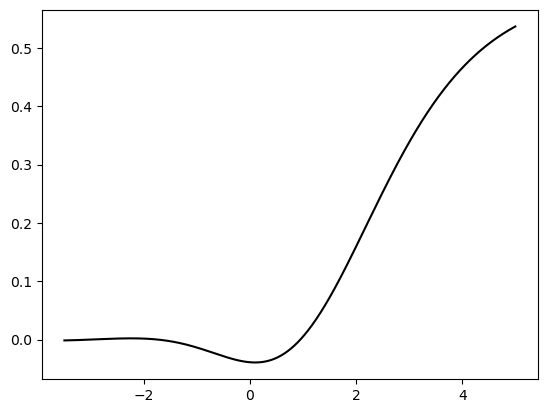

In [57]:
plt.plot(delta_beta, y-D_qc, color='black')